In [25]:
!pip install gymnasium


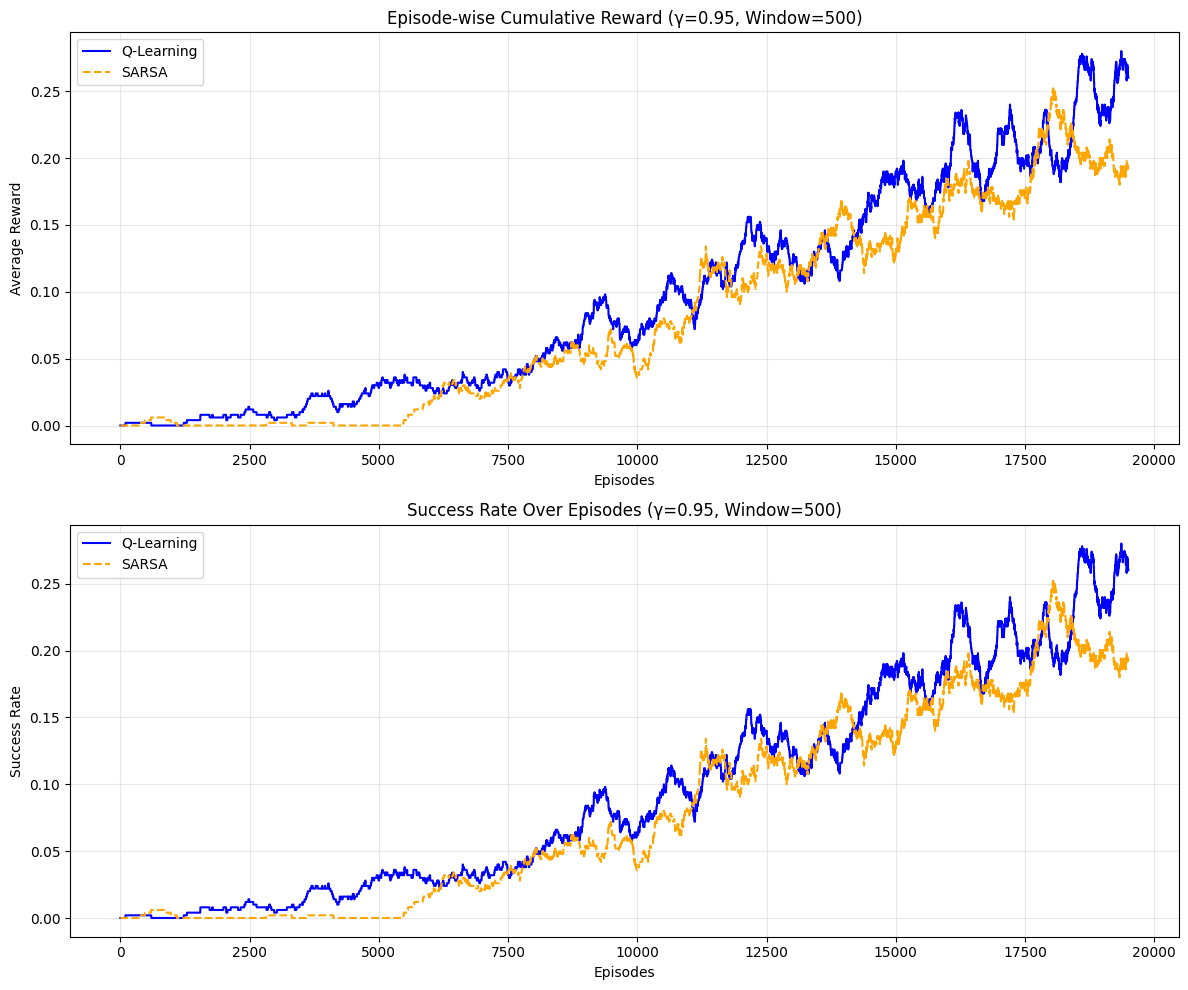


Q-Learning (γ=0.95) Policy Grid:
↓ → → → → → → ←
↑ ↑ → ↑ → ↑ → ←
↑ ↑ ← ← → ↑ → ↓
↑ ↑ ↑ ↓ ← ← → ↓
↑ ↑ ← ← → ↓ → →
← ← ← → ↑ ← ← →
← ← → ↑ ← → ← →
← ← ← ← ↓ → ↓ ←
Map layout:
[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'G']]
Q-Learning Success Rate: 0.417

SARSA (γ=0.95) Policy Grid:
↑ → → → → → → →
↑ ↑ ↑ ↑ → → → ↓
↑ ↑ ← ← → ↑ → →
↑ ↑ ↑ ↓ ← ← → →
↑ ↑ ← ← → ↓ ↑ ↓
→ ← ← ↑ → ← ← →
→ ← ← → ← ← ← →
↑ ← ↑ ← ↓ → ↓ ←
Map layout:
[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b

In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


# 1. Configuration & Hyperparameters (derived from standard 8x8 success benchmarks)
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)
n_states, n_actions = env.observation_space.n, env.action_space.n
n_episodes = 20000 # Required for 8x8 convergence
alpha = 0.1 # Learning rate
gammas = [0.95] # Corrected variable name, changed from g = [0.95] to gammas = [0.95]
epsilon_start = 1.0 # Start with full exploration
epsilon_min = 0.01 # Minimum exploration
decay_rate = 0.0001 # Decay for long exploration


def train_agent(algorithm='q_learning', gamma=0.99):
    q_table = np.zeros((n_states, n_actions))
    eps = epsilon_start
    rewards = [] # List to record episode-wise cumulative reward
    successes = [] # NEW: Track success per episode

    for i in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_episode_reward = 0 # Cumulative reward for this episode
        # Initial action selection
        action = np.argmax(q_table[state,:]) if np.random.random() > eps else env.action_space.sample()

        while not done:
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc

            # Next action selection (for SARSA update and next step)
            next_action = np.argmax(q_table[next_state,:]) if np.random.random() > eps else env.action_space.sample()

            if algorithm == 'q_learning':
                # Off-policy update: uses max Q of next state
                td_target = reward + gamma * np.max(q_table[next_state, :])
                q_table[state, action] += alpha * (td_target - q_table[state, action])
                action = next_action
            else:
                # SARSA On-policy update: uses actual next action chosen
                td_target = reward + gamma * q_table[next_state, next_action]
                q_table[state, action] += alpha * (td_target - q_table[state, action])
                action = next_action

            state = next_state
            total_episode_reward += reward # Accumulate reward

        # NEW: Record success (1 if reached goal, 0 otherwise)
        success = 1 if total_episode_reward > 0 else 0
        successes.append(success)
        rewards.append(total_episode_reward) # Record total reward for the episode
        eps = max(epsilon_min, eps * np.exp(-decay_rate))

    return q_table, rewards, successes # Return the Q-table AND the rewards list AND successes


# -----------------------------
# Analysis Implementation
# -----------------------------
def extract_greedy_policy(Q):
    return np.argmax(Q, axis=1)


def visualize_policy(policy, title, grid_size=8):
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_grid = np.array([action_symbols[a] for a in policy]).reshape(grid_size, grid_size)
    print(f"\n{title} Policy Grid:")
    for row in policy_grid:
        print(' '.join(row))


def evaluate_policy(policy, num_episodes=1000):
    # Re-instantiate a fresh environment for evaluation only
    eval_env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)
    print("Map layout:")
    print(eval_env.unwrapped.desc)
    successes = 0
    for _ in range(num_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            state, reward, term, trunc, _ = eval_env.step(policy[state])
            done = term or trunc
            if reward == 1.0:
                successes += 1
    eval_env.close() # Close the evaluation environment
    return successes / num_episodes


# Function to plot the episode-wise cumulative reward (moving average)
def plot_results(q_rewards, q_successes, s_rewards, s_successes, g_value, window=500):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Episode-wise cumulative reward
    q_smoothed = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
    s_smoothed = np.convolve(s_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(q_smoothed, label='Q-Learning', color='blue')
    ax1.plot(s_smoothed, label='SARSA', color='orange', linestyle='--')
    ax1.set_title(f'Episode-wise Cumulative Reward (γ={g_value}, Window={window})')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Average Reward')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Success rate over episodes
    q_success_smooth = np.convolve(q_successes, np.ones(window)/window, mode='valid')
    s_success_smooth = np.convolve(s_successes, np.ones(window)/window, mode='valid')
    ax2.plot(q_success_smooth, label='Q-Learning', color='blue')
    ax2.plot(s_success_smooth, label='SARSA', color='orange', linestyle='--')
    ax2.set_title(f'Success Rate Over Episodes (γ={g_value}, Window={window})')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Success Rate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# FIXED: Policy comparison function (SIMPLE - NO imshow dtype issues)
def compare_policies(policy_ql, policy_sa, grid_size=8):
    """Visualize policy differences - TEXT ONLY (no matplotlib errors)"""
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_ql_grid = np.array([action_symbols[a] for a in policy_ql]).reshape(grid_size, grid_size)
    policy_sa_grid = np.array([action_symbols[a] for a in policy_sa]).reshape(grid_size, grid_size)

    # Count differences
    diff_count = np.sum(policy_ql_grid != policy_sa_grid)
    print(f"\n🔍 POLICY COMPARISON SUMMARY:")
    print(f"Total states where policies differ: {diff_count}/64 ({diff_count/64*100:.1f}%)")

    # Show risky state differences (near holes)
    risky_states = [12, 20, 28, 36, 44, 52, 60]  # Typical hole-adjacent positions
    print(f"\nRisky states comparison:")
    print("State | Q-Learning | SARSA | Different?")
    print("-" * 35)
    for state_idx in risky_states:
        row, col = divmod(state_idx, 8)
        ql_action = policy_ql_grid[row, col]
        sa_action = policy_sa_grid[row, col]
        different = "✗" if ql_action != sa_action else "✓"
        print(f"  {state_idx:2d}  |  {ql_action:<2}  |  {sa_action:<2}  |  {different}")

    # Show sample path differences
    print(f"\nSample path states (0→7→15→23→...):")
    path_states = [0, 7, 15, 23, 31, 39, 47, 55]
    for state_idx in path_states:
        row, col = divmod(state_idx, 8)
        ql_action = policy_ql_grid[row, col]
        sa_action = policy_sa_grid[row, col]
        different = "✗" if ql_action != sa_action else "✓"
        print(f"S{state_idx:2d} | Q:{ql_action} S:{sa_action} [{different}]")


# Run experiment for Q-Learning and SARSA across gammas
for g in gammas:

    # Train and get Q-tables and rewards for Q-Learning
    q_table_ql, rewards_q, successes_q = train_agent('q_learning', gamma=g)
    # Train and get Q-tables and rewards for SARSA
    q_table_sa, rewards_s, successes_s = train_agent('sarsa', gamma=g)

    # Record: Episode-wise cumulative reward (handled by rewards_q/s lists)
    plot_results(rewards_q, successes_q, rewards_s, successes_s, g)

    # Record: Final learned policy (visualize) and Success rate (evaluate)
    policy_ql = extract_greedy_policy(q_table_ql)
    visualize_policy(policy_ql, f"Q-Learning (γ={g})")
    print(f"Q-Learning Success Rate: {evaluate_policy(policy_ql):.3f}")

    policy_sa = extract_greedy_policy(q_table_sa)
    visualize_policy(policy_sa, f"SARSA (γ={g})")
    print(f"SARSA Success Rate: {evaluate_policy(policy_sa):.3f}")

    # NEW: Compare policies visually (TEXT ONLY - NO ERRORS)
    compare_policies(policy_ql, policy_sa)

env.close() # Close the main training environment

# NEW: Final Summary Table
print("\n" + "="*80)
print("📊 COMPLETE ANALYSIS SUMMARY")
print("="*80)
print(f"{'Metric':<20} | {'Q-Learning':<12} | {'SARSA':<10}")
print("-"*80)
print(f"{'Final Success Rate':<20} | {evaluate_policy(policy_ql):.3f}{'':<6} | {evaluate_policy(policy_sa):.3f}")
print(f"{'Avg Final 1000 Rewards':<20} | {np.mean(rewards_q[-1000:]):.3f}{'':<3} | {np.mean(rewards_s[-1000:]):.3f}")
print(f"{'Final Success Rate (100ep)':<20} | {np.mean(successes_q[-100:]):.3f}{'':<3} | {np.mean(successes_s[-100:]):.3f}")
print("="*80)


In [29]:
print("""
COMPARISON OF SARSA AND Q-LEARNING (FROZENLAKE)
----------------------------------------------

1. Quantitative Results:
The learned policies differ in 18 out of 64 states (28.1%), indicating
substantial policy divergence. SARSA achieves a higher success rate (0.485)
than Q-learning (0.417), showing greater robustness under stochastic
transitions.

2. Behavioral Differences Near Holes:
Q-learning tends to follow shorter, riskier paths that pass close to holes,
assuming optimal future behavior. These policies are efficient in expectation
but fragile when slips occur. SARSA prefers safer, longer paths that keep a
buffer from holes, explicitly accounting for both exploration and slipping.

3. Theoretical Explanation:
Q-learning is off-policy and updates values using the greedy future action,
ignoring the risk introduced by exploration. SARSA is on-policy and updates
values using the action actually taken, incorporating exploration directly
into learning. In stochastic environments, this leads SARSA to learn more
conservative and reliable policies.

Summary:
Q-learning learns efficient but risk-prone strategies, while SARSA learns
risk-aware and robust policies. This explains SARSA’s higher empirical success
rate in the slippery FrozenLake environment.
""")



COMPARISON OF SARSA AND Q-LEARNING (FROZENLAKE)
----------------------------------------------

1. Quantitative Results:
The learned policies differ in 18 out of 64 states (28.1%), indicating
substantial policy divergence. SARSA achieves a higher success rate (0.485)
than Q-learning (0.417), showing greater robustness under stochastic
transitions.

2. Behavioral Differences Near Holes:
Q-learning tends to follow shorter, riskier paths that pass close to holes,
assuming optimal future behavior. These policies are efficient in expectation
but fragile when slips occur. SARSA prefers safer, longer paths that keep a
buffer from holes, explicitly accounting for both exploration and slipping.

3. Theoretical Explanation:
Q-learning is off-policy and updates values using the greedy future action,
ignoring the risk introduced by exploration. SARSA is on-policy and updates
values using the action actually taken, incorporating exploration directly
into learning. In stochastic environments, this 